In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import sys
print(sys.executable)

/cluster/home/9339yk/ml23_fmri_group_20a/venv/bin/python


In [3]:
import glob
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from skimage import color
from tensorflow import keras
from skimage import io
from skimage.transform import resize

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        print('enable gpu')
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

enable gpu
1 Physical GPUs, 1 Logical GPUs


2023-12-06 17:14:01.460787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 17:14:02.726885: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 17:14:02.727038: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
ROOT_FILE_PATH = "../REAL"
AREAS = ["prf-visualrois", "floc-bodies", "floc-faces", "floc-places", "floc-words", "streams", "all-vertices"]
MASK_KEYS = ["lh.fsaverage_space", "rh.fsaverage_space", "lh.space", "rh.space", "mapping"]

In [6]:
def ReadNpyFile(dir_path):
  return_dic = {}
  for path in glob.glob(dir_path + "/*.npy"):
    filename = os.path.splitext(path)[0].split("/")[-1]
    return_dic[filename] = np.load(path, allow_pickle = True)
  return return_dic

def ReadFmriFile(dir_path):
  return_dic = {}
  for path in glob.glob(dir_path + "/*.npy"):
    filename = os.path.splitext(path)[0].split("/")[-1]
    return_dic[filename[0]] = np.load(path, allow_pickle = True)
  return return_dic

def ReadMaskFile(dir_path):
  return_dic = {area: {} for area in AREAS}
  for path in glob.glob(dir_path + "/*.npy"):
    filename = os.path.splitext(path)[0].split("/")[-1]
    for area in AREAS:
      if area in filename:
        filename = "".join(i.strip("_") for i in filename.split(area))
        return_dic[area][filename] = np.load(path, allow_pickle = True) if filename[0] != "m" else np.load(path, allow_pickle = True).item()
        break
  return return_dic

def FetchPngFile(dir_path, index, mode = "rgb"):
  # img = iio.v3.imread()
  img = io.imread(os.path.join(dir_path, f'{index}.png'))
  if mode == "rgb":
    return img
  if mode == "hsv":
    return color.rgb2hsv(img)
    # return matplotlib.colors.rgb_to_hsv(img)
  if mode == "gray":
    return color.rgb2gray(img)
    # return np.dot(img, [0.299, 0.587, 0.114])

In [7]:
def train_val_split(x, y, ratio, random_state=42):
  
  r = np.random.RandomState(random_state)
  
  idx = r.permutation(x.index)
  x_per = x.reindex(idx)
  y_per = y.reindex(idx)

  train_size = int(x.shape[0] * ratio)
  
  x_train = x_per[0:train_size]
  y_train = y_per[0:train_size]
  
  x_val = x_per[train_size:]
  y_val = y_per[train_size:]
  
  print('Training_dimension: ' + str(x_train.shape) + ' | ' + str(y_train.shape))
  print('Validation_dimension: ' + str(x_val.shape) + ' | ' + str(y_val.shape))

  return x_train, x_val, y_train, y_val

In [8]:
class ReadObject:
  
  fmri = None           # dict(string -> ndarray, float32)
  masks = None          # dict(string "AREA" -> (dict(int -> string), string "HEMISPHERE, " -> ndarray))
  
  image_labels = None   # dataframe
  label_names = None    # list

  subject = None        # string
  
  def __init__(self, subject):
    self.subject = subject

  # Mode = "train" | "test"
  def load(self, mode = "train"):
    
    self.image_labels = pd.read_csv(os.path.join(ROOT_FILE_PATH, "image_infos", f"{self.subject}_infos_train.csv"))
    self.image_labels = self.image_labels.drop(self.image_labels.columns[[0, 1]], axis=1)
    self.label_names = self.image_labels.columns
    
    self.image_labels = self.image_labels.to_numpy(dtype=int)

    print('Images: ' + str(self.image_labels.shape[0]))
    print('Labels: ' + str(self.image_labels.shape[1]))
    
    self.masks = ReadMaskFile(os.path.join(ROOT_FILE_PATH, self.subject , "roi_masks"))
    print('Masks: ' + str(len(self.masks.keys())))
        
    if mode == "train":
      self.fmri = ReadFmriFile(os.path.join(ROOT_FILE_PATH, self.subject, "training_split", "training_fmri"))
    elif mode == "test":
      self.fmri = ReadFmriFile(os.path.join(ROOT_FILE_PATH, self.subject, "test_split", "test_fmri"))

  def split_data(self, count=None, ratio=None, permutate=True, image_mode = "rgb", random_state=42):
    
    if ratio is None:
      ratio = 1
    
    random_state = np.random.RandomState(random_state)
    
    if count is not None and count > 0:
      fmri_l_copy = self.fmri['l'][:count]
      fmri_r_copy = self.fmri['r'][:count]
      labels_copy = self.image_labels[:count]
    else:
      fmri_l_copy = self.fmri['l']
      fmri_r_copy = self.fmri['r']
      labels_copy = self.image_labels
    
    loaded_images = np.stack([FetchPngFile(os.path.join(ROOT_FILE_PATH, self.subject,
                      "training_split", "training_images"), i, mode = image_mode) for i in range(labels_copy.shape[0])])
    
    if permutate:
      
        idx = random_state.permutation(labels_copy.shape[0])
        
        fmri_l_copy = fmri_l_copy[idx]
        fmri_r_copy = fmri_r_copy[idx]
        labels_copy = labels_copy[idx]
        loaded_images = loaded_images[idx]
        
    train_size = int(labels_copy.shape[0] * ratio)
  
    fmri_l_train = fmri_l_copy[0:train_size]
    fmri_r_train = fmri_r_copy[0:train_size]
    labels_train = labels_copy[0:train_size]
    images_train = loaded_images[0:train_size]
    
    fmri_l_val = fmri_l_copy[train_size:]
    fmri_r_val = fmri_r_copy[train_size:]
    labels_val = labels_copy[train_size:]
    images_val = loaded_images[train_size:]
    
    return (labels_train, labels_val), (fmri_l_train, fmri_l_val), (fmri_r_train, fmri_r_val), (images_train, images_val)

In [9]:
%matplotlib inline
def test_data(label_names, labels_list, image, fmri_l, fmri_r):
  labels = np.array(label_names)[np.where(labels_list != 0)] 
  print(labels)
  plt.imshow(image, cmap='gray')
  plt.show()

In [10]:
SUBJ_LIST = ["subj01", "subj02", "subj03", "subj04", "subj05", "subj06", "subj07", "subj08"]

In [11]:
def min_max_normalize(X, min=0, max=1):
  
  # Define the original range
  old_min = np.min(X)
  old_max = np.max(X)
  
  # Map the values from the original range to the new range
  X = (np.array(X, dtype='float32') - old_min) * (max - min) / (old_max - old_min) + min
  
  return X

In [12]:
global_labels_name = None
global_labels_train = None
global_labels_val = None
global_fmri_l_train = None
global_fmri_l_val = None
global_fmri_r_train = None
global_fmri_r_val = None
global_images_train = None
global_images_val = None

subject_count = 2

image_mode = "gray"

for sub in SUBJ_LIST[:subject_count]:
  
  print(sub)
  
  sub_obj = ReadObject(sub)
  sub_obj.load()
  
  global_labels_name = sub_obj.label_names if global_labels_name is None else global_labels_name
  
  (
    (labels_train, labels_val), (fmri_l_train, fmri_l_val),
    (fmri_r_train, fmri_r_val), (images_train, images_val)
  ) = (sub_obj.split_data(count=5000, ratio=0.995, image_mode=image_mode))
  
  print(f"labels_train  shape: {labels_train.shape}")
  global_labels_train = labels_train if global_labels_train is None else np.vstack((global_labels_train, labels_train))
  
  print(f"labels_val  shape: {labels_val.shape}")
  global_labels_val = labels_val if global_labels_val is None else np.vstack((global_labels_val, labels_val))
  
  fmri_l_train = min_max_normalize(fmri_l_train)
  print(f"fmri_l_train  shape: {fmri_l_train.shape} | min: {np.min(fmri_l_train)} max: {np.max(fmri_l_train)}")
  global_fmri_l_train = fmri_l_train if global_fmri_l_train is None else np.vstack((global_fmri_l_train, fmri_l_train))
  
  fmri_l_val = min_max_normalize(fmri_l_val)
  print(f"fmri_l_val  shape: {fmri_l_val.shape} | min: {np.min(fmri_l_val)} max: {np.max(fmri_l_val)}")
  global_fmri_l_val = fmri_l_val if global_fmri_l_val is None else np.vstack((global_fmri_l_val, fmri_l_val))
  
  fmri_r_train = min_max_normalize(fmri_r_train)
  print(f"fmri_r_train  shape: {fmri_r_train.shape} | min: {np.min(fmri_r_train)} max: {np.max(fmri_r_train)}")
  global_fmri_r_train = fmri_r_train if global_fmri_r_train is None else np.vstack((global_fmri_r_train, fmri_r_train))
  
  fmri_r_val = min_max_normalize(fmri_r_val)
  print(f"fmri_r_val  shape: {fmri_r_val.shape} | min: {np.min(fmri_r_val)} max: {np.max(fmri_r_val)}")
  global_fmri_r_val = fmri_r_val if global_fmri_r_val is None else np.vstack((global_fmri_r_val, fmri_r_val))
  
  if image_mode == 'rgb':
    images_train = min_max_normalize(images_train)
  elif image_mode == 'gray':
    images_train = images_train.reshape((-1, images_train.shape[1], images_train.shape[2], 1))
  print(f"images_train  shape: {images_train.shape} | min: {np.min(images_train)} max: {np.max(images_train)}")
  global_images_train = images_train if global_images_train is None else np.vstack((global_images_train, images_train))
  
  if image_mode == 'rgb':
    images_val = min_max_normalize(images_val)
  elif image_mode == 'gray':
    images_val = images_val.reshape((-1, images_val.shape[1], images_val.shape[2], 1))
  print(f"images_val  shape: {images_val.shape} | min: {np.min(images_val)} max: {np.max(images_val)}")
  global_images_val = images_val if global_images_val is None else np.vstack((global_images_val, images_val))

subj01
Images: 5000
Labels: 133
Masks: 7
labels_train  shape: (4975, 133)
labels_val  shape: (25, 133)
fmri_l_train  shape: (4975, 19004) | min: 0.0 max: 1.0
fmri_l_val  shape: (25, 19004) | min: 0.0 max: 1.0
fmri_r_train  shape: (4975, 20544) | min: 0.0 max: 1.0
fmri_r_val  shape: (25, 20544) | min: 0.0 max: 1.0
images_train  shape: (4975, 425, 425, 1) | min: 0.0 max: 1.0
images_val  shape: (25, 425, 425, 1) | min: 0.0 max: 1.0
subj02
Images: 5000
Labels: 133
Masks: 7
labels_train  shape: (4975, 133)
labels_val  shape: (25, 133)
fmri_l_train  shape: (4975, 19004) | min: 0.0 max: 1.0
fmri_l_val  shape: (25, 19004) | min: 0.0 max: 1.0
fmri_r_train  shape: (4975, 20544) | min: 0.0 max: 1.0
fmri_r_val  shape: (25, 20544) | min: 0.0 max: 1.0
images_train  shape: (4975, 425, 425, 1) | min: 0.0 max: 1.0
images_val  shape: (25, 425, 425, 1) | min: 0.0 max: 1.0


In [13]:
print('Global shapes:')
print(global_labels_train.shape)
print(global_labels_val.shape)
print(global_fmri_l_train.shape)
print(global_fmri_l_val.shape)
print(global_fmri_r_train.shape)
print(global_fmri_r_val.shape)
print(global_images_train.shape)
print(global_images_val.shape)

Global shapes:
(9950, 133)
(50, 133)
(9950, 19004)
(50, 19004)
(9950, 20544)
(50, 20544)
(9950, 425, 425, 1)
(50, 425, 425, 1)


Label test 184:
['person' 'cup' 'tv' 'laptop' 'cell phone' 'vase' 'scissors'
 'mirror-stuff' 'shelf' 'table-merged' 'paper-merged' 'wall-other-merged']


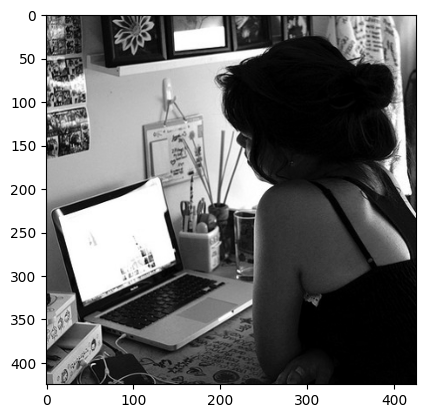

In [14]:
label_test_index = 184
print(f'Label test {label_test_index}:')
test_data(global_labels_name, global_labels_train[label_test_index], global_images_train[label_test_index], None, None)

In [15]:
print(f'Combined fmri data train:')
print(global_fmri_l_train.shape)
print(global_fmri_r_train.shape)
global_X_train = np.concatenate((global_fmri_l_train, global_fmri_r_train), axis=1)

print(global_X_train.shape)

print(f'Combined fmri data val:')

print(global_fmri_l_val.shape)
print(global_fmri_r_val.shape)
global_X_val  = np.concatenate((global_fmri_l_val, global_fmri_r_val), axis=1)

print(global_X_val.shape)

Combined fmri data train:
(9950, 19004)
(9950, 20544)
(9950, 39548)
Combined fmri data val:
(50, 19004)
(50, 20544)
(50, 39548)


In [16]:
print(f'Global labels:')
global_Y_train_classification = global_labels_train
print(global_Y_train_classification.shape)

Global labels:
(9950, 133)


# Image classification

In [18]:
model = keras.models.Sequential()

model.add(keras.layers.Conv1D(filters=32, kernel_size=(5,), input_shape=(39548, 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.Conv1D(filters=32, kernel_size=(5,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.MaxPool1D())

model.add(keras.layers.Conv1D(filters=64, kernel_size=(4,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.Conv1D(filters=64, kernel_size=(4,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.MaxPool1D())

model.add(keras.layers.Conv1D(filters=128, kernel_size=(3,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.Conv1D(filters=128, kernel_size=(3,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.MaxPool1D())

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dense(133, activation="softmax"))

model.compile(
  optimizer= keras.optimizers.SGD(learning_rate=0.00001), loss= keras.losses.CategoricalCrossentropy(), 
  metrics= [keras.metrics.CategoricalAccuracy()]) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 39544, 32)         192       
                                                                 
 batch_normalization (Batch  (None, 39544, 32)         128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 39544, 32)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 39540, 32)         5152      
                                                                 
 batch_normalization_1 (Bat  (None, 39540, 32)         128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 39540, 32)         0

In [20]:
history = model.fit(global_X_train.reshape(-1, global_X_train.shape[1], 1), global_labels_train, 
                    validation_data=(global_X_val, global_labels_val), batch_size=64, epochs=10)

Epoch 1/10
156/156 [==============================] - 25s 162ms/step - loss: 48.7198 - categorical_accuracy: 0.3742 - val_loss: 35.7300 - val_categorical_accuracy: 0.1600
Epoch 2/10
156/156 [==============================] - 23s 150ms/step - loss: 132.3772 - categorical_accuracy: 0.3698 - val_loss: 91.3822 - val_categorical_accuracy: 0.2800
Epoch 3/10
156/156 [==============================] - 23s 149ms/step - loss: 494.6087 - categorical_accuracy: 0.3279 - val_loss: 707.2444 - val_categorical_accuracy: 0.3800
Epoch 4/10
156/156 [==============================] - 23s 150ms/step - loss: 18919.9121 - categorical_accuracy: 0.1906 - val_loss: 589158.7500 - val_categorical_accuracy: 0.0000e+00
Epoch 5/10
156/156 [==============================] - 23s 146ms/step - loss: nan - categorical_accuracy: 0.4590 - val_loss: nan - val_categorical_accuracy: 0.4400
Epoch 6/10
156/156 [==============================] - 23s 146ms/step - loss: nan - categorical_accuracy: 0.5034 - val_loss: nan - val_categ

In [25]:
# Accessing training history
print(history.history.keys())
training_loss = history.history['loss']
training_accuracy = history.history['categorical_accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_categorical_accuracy']

# Printing training and validation loss and accuracy
for i in range(len(training_loss)):
    print(f"Epoch {i+1}: Training Loss: {training_loss[i]}, Training Accuracy: {training_accuracy[i]}, Validation Loss: {validation_loss[i]}, Validation Accuracy: {validation_accuracy[i]}")

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])
Epoch 1: Training Loss: 48.71979904174805, Training Accuracy: 0.37417083978652954, Validation Loss: 35.73003387451172, Validation Accuracy: 0.1599999964237213
Epoch 2: Training Loss: 132.3771514892578, Training Accuracy: 0.36984923481941223, Validation Loss: 91.3822250366211, Validation Accuracy: 0.2800000011920929
Epoch 3: Training Loss: 494.6087341308594, Training Accuracy: 0.3279396891593933, Validation Loss: 707.2444458007812, Validation Accuracy: 0.3799999952316284
Epoch 4: Training Loss: 18919.912109375, Training Accuracy: 0.19055277109146118, Validation Loss: 589158.75, Validation Accuracy: 0.0
Epoch 5: Training Loss: nan, Training Accuracy: 0.45899498462677, Validation Loss: nan, Validation Accuracy: 0.4399999976158142
Epoch 6: Training Loss: nan, Training Accuracy: 0.5034170746803284, Validation Loss: nan, Validation Accuracy: 0.4399999976158142
Epoch 7: Training Loss: nan, Training Accuracy: 0

In [26]:
prediction_model = model.predict(global_X_val.reshape(-1, global_X_train.shape[1], 1))
print(prediction_model.shape)

2/2 [==============================] - 1s 232ms/step
(50, 133)


In [30]:
print(prediction_model[1])

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]


['person' 'bicycle' 'car' 'bus' 'train' 'banner' 'road' 'window-other'
 'tree-merged' 'ceiling-merged' 'sky-other-merged' 'pavement-merged'
 'mountain-merged' 'dirt-merged' 'building-other-merged'
 'wall-other-merged']


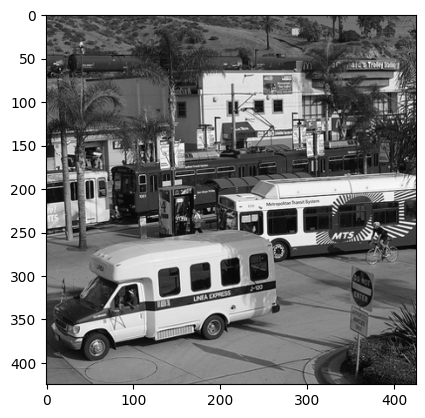

In [31]:
prediction_model_index = 16
test_data(global_labels_name, global_labels_val[prediction_model_index], global_images_val[prediction_model_index], None, None)

In [32]:
label_count = 3
print(prediction_model[prediction_model_index])
top_3_indices = np.argsort(prediction_model[prediction_model_index])[-label_count:][::-1]
top_3_values = prediction_model[prediction_model_index][top_3_indices]
print(f"Top 3 indices: {top_3_indices} | Top 3 values: {top_3_values}")
print("Top 3 labels:", global_labels_name[top_3_indices])

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
Top 3 indices: [132  48  34] | Top 3 values: [nan nan nan]
Top 3 labels: Index(['rug-merged', 'sandwich', 'baseball bat'], dtype='object')


In [33]:
print('Fill up fmri with zeros till 40000')

target_size = 40000

additional_rows = np.zeros(shape=(global_X_train.shape[0], target_size - global_X_train.shape[1]))
# print(additional_rows.shape)

expanded_40000_X_train = np.concatenate((global_X_train, additional_rows), axis=1)
print(expanded_40000_X_train.shape)

additional_rows2 = np.zeros(shape=(global_X_val.shape[0], target_size - global_X_val.shape[1]))
expanded_40000_X_val = np.concatenate((global_X_val, additional_rows2), axis=1)
print(expanded_40000_X_val.shape)

Fill up fmri with zeros till 40000
(9950, 40000)
(50, 40000)


In [34]:
## Resize images
size = 300
count = 100
resized_300_Y_train_images = np.zeros((count, size, size, global_images_train.shape[3]))
for index in range(count):
  if index % 50 == 0:
    print(index)
  resized_300_Y_train_images[index] = resize(global_images_train[index], (size, size, global_images_train.shape[3]), anti_aliasing=True)
print(resized_300_Y_train_images.shape)

0
50
(100, 300, 300, 1)


In [35]:
encoder1 = keras.models.Sequential()

encoder1.add(keras.layers.Conv2D(1, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(200, 200, 1)))
encoder1.add(keras.layers.BatchNormalization())

encoder1.add(keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"))
encoder1.add(keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="sigmoid"))
encoder1.add(keras.layers.BatchNormalization())
encoder1.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

encoder1.add(keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"))
encoder1.add(keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"))
encoder1.add(keras.layers.BatchNormalization())
encoder1.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

encoder1.add(keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"))
encoder1.add(keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"))
encoder1.add(keras.layers.BatchNormalization())
encoder1.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
encoder1.summary()

decoder1 = keras.models.Sequential()

decoder1.add(keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(25, 25, 128)))
decoder1.add(keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="sigmoid"))
decoder1.add(keras.layers.BatchNormalization())
decoder1.add(keras.layers.UpSampling2D(size=(3, 3)))

decoder1.add(keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"))
decoder1.add(keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"))
decoder1.add(keras.layers.BatchNormalization())
decoder1.add(keras.layers.UpSampling2D(size=(2, 2)))

decoder1.add(keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"))
decoder1.add(keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"))
decoder1.add(keras.layers.BatchNormalization())
decoder1.add(keras.layers.UpSampling2D(size=(2, 2)))

decoder1.add(keras.layers.Conv2D(resized_300_Y_train_images.shape[3], kernel_size=(3, 3), padding="same", activation='sigmoid'))
decoder1.summary()

model1 = keras.models.Sequential()
model1.add(encoder1)
model1.add(decoder1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 1)       10        
                                                                 
 batch_normalization_6 (Bat  (None, 200, 200, 1)       4         
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      320       
                                                                 
 conv2d_2 (Conv2D)           (None, 200, 200, 32)      9248      
                                                                 
 batch_normalization_7 (Bat  (None, 200, 200, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 32)     

In [36]:
model1.compile(optimizer= keras.optimizers.SGD(learning_rate=0.0001), loss=keras.losses.BinaryCrossentropy())
#model1.compile(optimizer= keras.optimizers.SGD(learning_rate=0.0001), loss=keras.losses.MSE())
#model1.compile(optimizer= keras.optimizers.SGD(learning_rate=0.0001), loss='mae')

In [37]:
model1.fit(expanded_40000_X_train.reshape(-1, 200, 200)[:count], resized_300_Y_train_images, batch_size=32, epochs=10)

Epoch 1/10


2023-12-06 17:30:07.174715: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-12-06 17:30:07.760199: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-12-06 17:30:07.959710: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-12-06 17:30:08.006706: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-12-06 17:30:08.099645: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


4/4 [==============================] - 5s 159ms/step - loss: 0.8073
Epoch 2/10
4/4 [==============================] - 0s 29ms/step - loss: 0.8064
Epoch 3/10
4/4 [==============================] - 0s 28ms/step - loss: 0.8053
Epoch 4/10
4/4 [==============================] - 0s 28ms/step - loss: 0.8041
Epoch 5/10
4/4 [==============================] - 0s 28ms/step - loss: 0.8032
Epoch 6/10
4/4 [==============================] - 0s 28ms/step - loss: 0.8022
Epoch 7/10
4/4 [==============================] - 0s 28ms/step - loss: 0.8013
Epoch 8/10
4/4 [==============================] - 0s 28ms/step - loss: 0.8003
Epoch 9/10
4/4 [==============================] - 0s 28ms/step - loss: 0.7994
Epoch 10/10
4/4 [==============================] - 0s 28ms/step - loss: 0.7984


In [38]:
prediction_model1 = model1.predict(expanded_40000_X_val.reshape(-1, 200, 200))
print(prediction_model1.shape)

2/2 [==============================] - 1s 302ms/step
(50, 300, 300, 1)


['person' 'bicycle' 'car' 'bus' 'train' 'banner' 'road' 'window-other'
 'tree-merged' 'ceiling-merged' 'sky-other-merged' 'pavement-merged'
 'mountain-merged' 'dirt-merged' 'building-other-merged'
 'wall-other-merged']


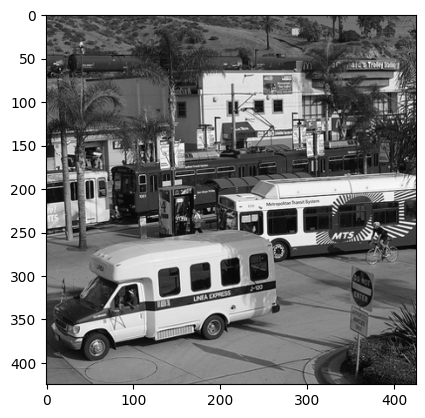

['person' 'bicycle' 'car' 'bus' 'train' 'banner' 'road' 'window-other'
 'tree-merged' 'ceiling-merged' 'sky-other-merged' 'pavement-merged'
 'mountain-merged' 'dirt-merged' 'building-other-merged'
 'wall-other-merged']


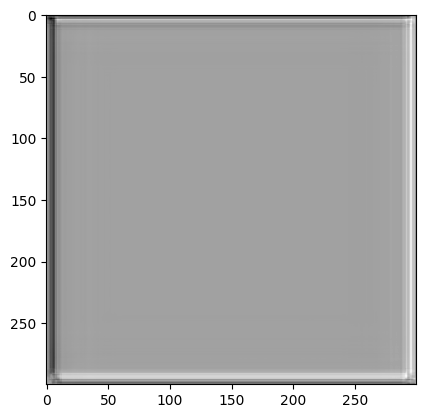

In [39]:
prediction_model1_index = 16
test_data(global_labels_name, global_labels_val[prediction_model1_index], global_images_val[prediction_model1_index], None, None)
test_data(global_labels_name, global_labels_val[prediction_model1_index], prediction_model1[prediction_model1_index], None, None)

In [40]:
## Resize images
size = 200
count = 100
resized_200_Y_train_images = np.zeros((count, size, size, global_images_train.shape[3]))
for index in range(count):
  if index % 50 == 0:
    print(index)
  resized_200_Y_train_images[index] = resize(global_images_train[index], (size, size, global_images_train.shape[3]), anti_aliasing=True)
print(resized_200_Y_train_images.shape)

0
50
(100, 200, 200, 1)


In [41]:
encoder2 = keras.models.Sequential()

encoder2.add(keras.layers.Conv2D(32, kernel_size=4, strides=2, input_shape=(200, 200, 1)))
encoder2.add(keras.layers.BatchNormalization())
encoder2.add(keras.layers.LeakyReLU())
encoder2.add(keras.layers.Dropout(0.1))

encoder2.add(keras.layers.Conv2D(64, kernel_size=3, strides=2))
encoder2.add(keras.layers.BatchNormalization())
encoder2.add(keras.layers.LeakyReLU())
encoder2.add(keras.layers.Dropout(0.1))
encoder2.summary()

bridge2 = keras.models.Sequential()

bridge2.add(keras.layers.Conv2D(128, kernel_size=3, strides=2, input_shape=(49, 49, 64)))
bridge2.summary()

decoder2 = keras.models.Sequential()

decoder2.add(keras.layers.BatchNormalization(input_shape=(24, 24, 128)))
decoder2.add(keras.layers.LeakyReLU())
decoder2.add(keras.layers.Dropout(0.1))

decoder2.add(keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2))
decoder2.add(keras.layers.BatchNormalization())
decoder2.add(keras.layers.LeakyReLU())
decoder2.add(keras.layers.Dropout(0.1))

decoder2.add(keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2))
decoder2.add(keras.layers.BatchNormalization())
decoder2.add(keras.layers.LeakyReLU())
decoder2.add(keras.layers.Dropout(0.1))

decoder2.add(keras.layers.Conv2DTranspose(3, kernel_size=4, strides=2))

decoder2.summary()

model2 = keras.models.Sequential()

model2.add(encoder2)
model2.add(bridge2)
model2.add(decoder2)

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 99, 99, 32)        544       
                                                                 
 batch_normalization_13 (Ba  (None, 99, 99, 32)        128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 99, 99, 32)        0         
                                                                 
 dropout (Dropout)           (None, 99, 99, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 49, 49, 64)        18496     
                                                                 
 batch_normalization_14 (Ba  (None, 49, 49, 64)        256       
 tchNormalization)                                    

In [44]:
model2.compile(optimizer= keras.optimizers.SGD(learning_rate=0.0001), loss=keras.losses.BinaryCrossentropy())
# model2.compile(optimizer= keras.optimizers.SGD(learning_rate=0.0001), loss=keras.losses.MSE())
#model2.compile(optimizer=keras.optimizers.SGD(learning_rate=0.0001), loss='mae')

In [45]:
model2.fit(expanded_40000_X_train.reshape(-1, 200, 200)[:count], resized_200_Y_train_images, batch_size=64, epochs=60)

Epoch 1/60


2023-12-06 17:31:58.475185: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/sequential_4/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-06 17:31:58.669590: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-12-06 17:31:58.669607: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-12-06 17:31:58.669618: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-12-06 17:31:58.669903: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to 

2/2 [==============================] - 2s 251ms/step - loss: 4.2488
Epoch 2/60
2/2 [==============================] - 0s 10ms/step - loss: 4.2456
Epoch 3/60
2/2 [==============================] - 0s 19ms/step - loss: 4.2414
Epoch 4/60
2/2 [==============================] - 0s 10ms/step - loss: 4.2362
Epoch 5/60
2/2 [==============================] - 0s 10ms/step - loss: 4.2304
Epoch 6/60
2/2 [==============================] - 0s 9ms/step - loss: 4.2293
Epoch 7/60
2/2 [==============================] - 0s 10ms/step - loss: 4.2255
Epoch 8/60
2/2 [==============================] - 0s 10ms/step - loss: 4.2216
Epoch 9/60
2/2 [==============================] - 0s 9ms/step - loss: 4.2178
Epoch 10/60
2/2 [==============================] - 0s 9ms/step - loss: 4.2143
Epoch 11/60
2/2 [==============================] - 0s 9ms/step - loss: 4.2099
Epoch 12/60
2/2 [==============================] - 0s 10ms/step - loss: 4.2074
Epoch 13/60
2/2 [==============================] - 0s 9ms/step - loss: 4.20

In [46]:
prediction_model2 = model2.predict(expanded_40000_X_val.reshape(-1, 200, 200))
print(prediction_model2.shape)

2/2 [==============================] - 0s 65ms/step
(50, 200, 200, 3)


['person' 'motorcycle' 'road' 'fence-merged' 'ceiling-merged'
 'pavement-merged' 'wall-other-merged']


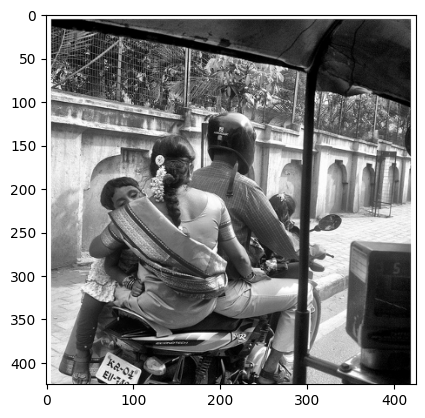

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['person' 'motorcycle' 'road' 'fence-merged' 'ceiling-merged'
 'pavement-merged' 'wall-other-merged']


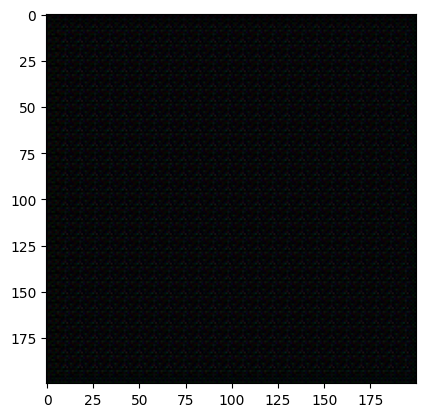

In [47]:
index = 4
test_data(global_labels_name, global_labels_val[index], global_images_val[index], None, None)
test_data(global_labels_name, global_labels_val[index], prediction_model2[index], None, None)